In [183]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns

In [184]:
train_df = pd.read_csv(r"datasets\dataset3_train.csv")
test_df = pd.read_csv(r"datasets\dataset3_test.csv")

train_df.info()
# test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Customer ID                  30000 non-null  object 
 1   Name                         30000 non-null  object 
 2   Gender                       29947 non-null  object 
 3   Age                          30000 non-null  int64  
 4   Income (USD)                 25424 non-null  float64
 5   Income Stability             28317 non-null  object 
 6   Profession                   30000 non-null  object 
 7   Type of Employment           22730 non-null  object 
 8   Location                     30000 non-null  object 
 9   Loan Amount Request (USD)    30000 non-null  float64
 10  Current Loan Expenses (USD)  29828 non-null  float64
 11  Expense Type 1               30000 non-null  object 
 12  Expense Type 2               30000 non-null  object 
 13  Dependents      

## Data Preprocessing

### Filtering unnecessary columns

In [185]:
train_df.drop(["Customer ID", "Name"],axis = 1, inplace=True)

### Encoding Categorical Variables

In [186]:


#ordinal encodings
ordinal_encodings = {
    "Income Stability":['Low', 'High'],
    "Location":['Rural', 'Semi-Urban', 'Urban'],
    "Has Active Credit Card":['Unpossessed', 'Inactive', 'Active'],
    "Property Location":['Rural', 'Semi-Urban', 'Urban'],
    "Gender": ["M","F"],
    "Expense Type 1": ['Y', 'N'],
    "Expense Type 2": ['Y', 'N']
}

columns_to_rank = {
    "Profession":{'Working':0, 'Pensioner':0, 'State servant':0, 'Commercial associate':0, 'Unemployed':0, 'Student':0, 'Businessman':0, 'Maternity leave':0},
    "Type of Employment":{'Sales staff':0, 'High skill tech staff':0, 'Secretaries':0, 'Laborers':0, 'Managers':0, 'Cooking staff':0, 'Core staff':0, 'Drivers':0, 'Realty agents':0, 'Security staff':0, 'Accountants':0, 'Private service staff':0, 'Waiters/barmen staff':0, 'Medicine staff':0, 'Cleaning staff':0, 'Low-skill Laborers':0, 'HR staff':0, 'IT staff':0},
}

for column in columns_to_rank:
    for param in columns_to_rank[column]:
        avg = train_df[train_df[column]==param]["Loan Sanction Amount (USD)"].mean()
        columns_to_rank[column][param]=avg

ordinal_encodings['Profession'] = sorted(columns_to_rank["Profession"], key = lambda x: columns_to_rank["Profession"][x])
ordinal_encodings['Type of Employment'] = sorted(columns_to_rank["Type of Employment"], key = lambda x: columns_to_rank["Type of Employment"][x])

for column in ordinal_encodings:
    encoder = OrdinalEncoder(
        categories=[ordinal_encodings[column]],
        handle_unknown="use_encoded_value",
        unknown_value=np.nan
    )
    encoder.set_output(transform="pandas")
    train_df[column] = encoder.fit_transform(train_df[[column]])


### Handling null values

In [187]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Gender                       29947 non-null  float64
 1   Age                          30000 non-null  int64  
 2   Income (USD)                 25424 non-null  float64
 3   Income Stability             28317 non-null  float64
 4   Profession                   30000 non-null  float64
 5   Type of Employment           22730 non-null  float64
 6   Location                     30000 non-null  float64
 7   Loan Amount Request (USD)    30000 non-null  float64
 8   Current Loan Expenses (USD)  29828 non-null  float64
 9   Expense Type 1               30000 non-null  float64
 10  Expense Type 2               30000 non-null  float64
 11  Dependents                   27507 non-null  float64
 12  Credit Score                 28297 non-null  float64
 13  No. of Defaults 

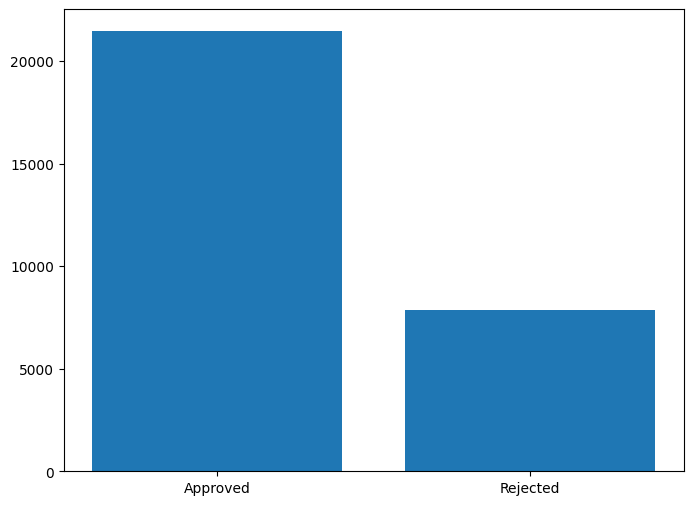

In [188]:
### too many loans(~7000) have been rejected (given a 0 value)

approved = train_df[train_df["Loan Sanction Amount (USD)"] > 0]
rejected = train_df[train_df["Loan Sanction Amount (USD)"] == 0]
counts = [len(approved), len(rejected)]
labels = ["Approved", "Rejected"]

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, counts)

plt.show()

In [189]:
## we observe -999 used as nulll values in following columns
null_999 = [
    "Loan Sanction Amount (USD)",   ##338 -999 values
    "Property Price",               ##341 -999 values
    "Co-Applicant",                 ##165 -999 values
    "Current Loan Expenses (USD)"   ##174 -999 values
]

train_df[null_999] = train_df[null_999].replace(-999,np.nan)
train_df["Loan Sanction Amount (USD)"] = train_df["Loan Sanction Amount (USD)"].replace(0,np.nan)
train_df["Property Age Null"] = train_df["Property Age"].isna().astype(int)
train_df["Employment Null"] = train_df["Type of Employment"].isna().astype(int)
null_columns = ["Gender", "Income (USD)", "Income Stability", "Type of Employment", "Current Loan Expenses (USD)", "Dependents", "Credit Score", "Has Active Credit Card", "Property Age", "Property Location"]
## we observe null values present in following columns

###Since loan sanction amount is the value to be predicted, columns with loansanctionamount null are removed
train_df.dropna(subset=["Loan Sanction Amount (USD)"],inplace=True)

#imputation
## fill median for Income (USD), Gender, Income Stability, Type of Employment, Current Loan Expenses (USD), Credit Score, Property Age
## fill 0 for Dependents
## fill Unposessed for Has Active Credit Card
## fill most frequent for Property Location


train_df["Dependents"] = train_df["Dependents"].fillna(0)
train_df["Has Active Credit Card"] = train_df["Has Active Credit Card"].fillna(0)
train_df["Property Location"] = train_df["Property Location"].fillna(1)
train_df["Gender"] = train_df["Gender"].fillna(0)
imputer = SimpleImputer(missing_values=np.nan, strategy="median")
imputer.set_output(transform="pandas")
train_df = imputer.fit_transform(train_df)



### standardizing numerical data

In [190]:
X = train_df.drop("Loan Sanction Amount (USD)", axis = 1)
y = train_df[["Loan Sanction Amount (USD)"]].copy()

## propert age, price, all usd have outliers

X["Current Loan Expenses (USD)"] = X["Current Loan Expenses (USD)"].apply(np.log1p)
X["Income (USD)"] = X["Income (USD)"].apply(np.log1p)
X["Loan Amount Request (USD)"] = X["Loan Amount Request (USD)"].apply(np.log1p)
X["Property Price"] = X["Property Price"].apply(np.log1p)
X["Property Age"] = X["Property Age"].apply(np.log1p)

y["Loan Sanction Amount (USD)"] = y["Loan Sanction Amount (USD)"].apply(np.log1p)

scaler = StandardScaler()
scaler.set_output(transform="pandas")

standard_scale_columns = [
    'Age', 'Income (USD)', 'Profession', 'Type of Employment', 'Location', 
    'Loan Amount Request (USD)', 'Current Loan Expenses (USD)', 'Dependents', 
    'Credit Score', 'Has Active Credit Card', 'Property ID', 'Property Age', 
    'Property Type', 'Property Location', 'Property Price'
]

for column in standard_scale_columns:
    X[column] = scaler.fit_transform(X[[column]])


## EDA

In [191]:
categorical_columns = [] # barchart
continuous_columns = [] # histogram
target_columns = ["Loan Sanction Amount (USD)"] #histogram
for i in X.columns:
    if len(X[i].unique())<20:
        categorical_columns.append(i)
    else:
        continuous_columns.append(i)

print(categorical_columns)
print(continuous_columns)
## 15 binary, 8 non binary, 1 target - 3 columns, 8 rows 


['Gender', 'Income Stability', 'Profession', 'Type of Employment', 'Location', 'Expense Type 1', 'Expense Type 2', 'Dependents', 'No. of Defaults', 'Has Active Credit Card', 'Property Type', 'Property Location', 'Co-Applicant', 'Property Age Null', 'Employment Null']
['Age', 'Income (USD)', 'Loan Amount Request (USD)', 'Current Loan Expenses (USD)', 'Credit Score', 'Property ID', 'Property Age', 'Property Price']


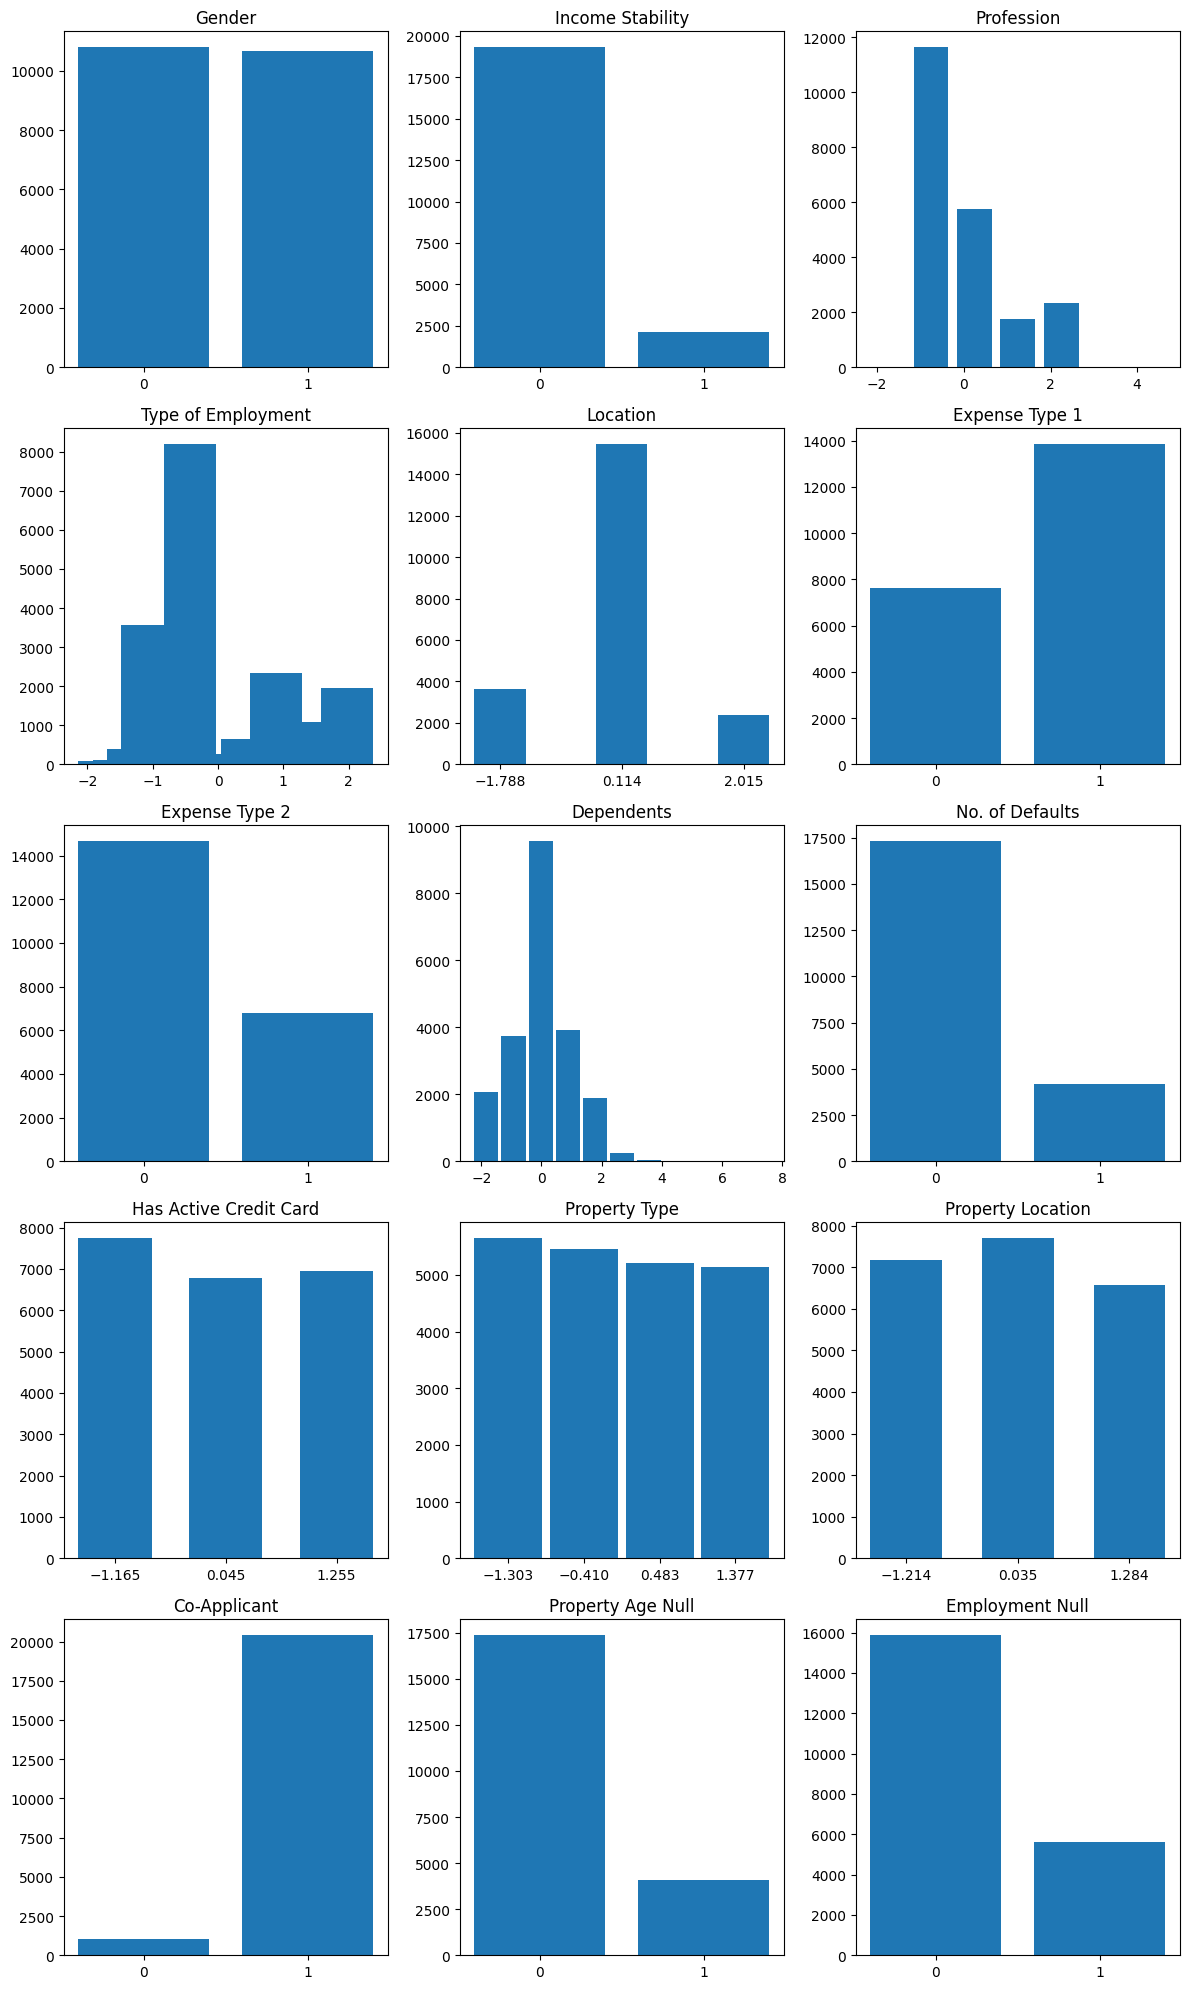

In [192]:
fig,axes = plt.subplots(nrows = 5, ncols = 3, figsize = (12,20))
axes = axes.flatten()
for i in range(15):
    categories = sorted(X[categorical_columns[i]].unique())
    heights = [X[X[categorical_columns[i]]==j][categorical_columns[i]].count() for j in categories]

    axes[i].set_title(categorical_columns[i])
    axes[i].bar(categories,heights)
    if len(categories)<5:
        axes[i].set_xticks(categories)

plt.tight_layout()
plt.show()

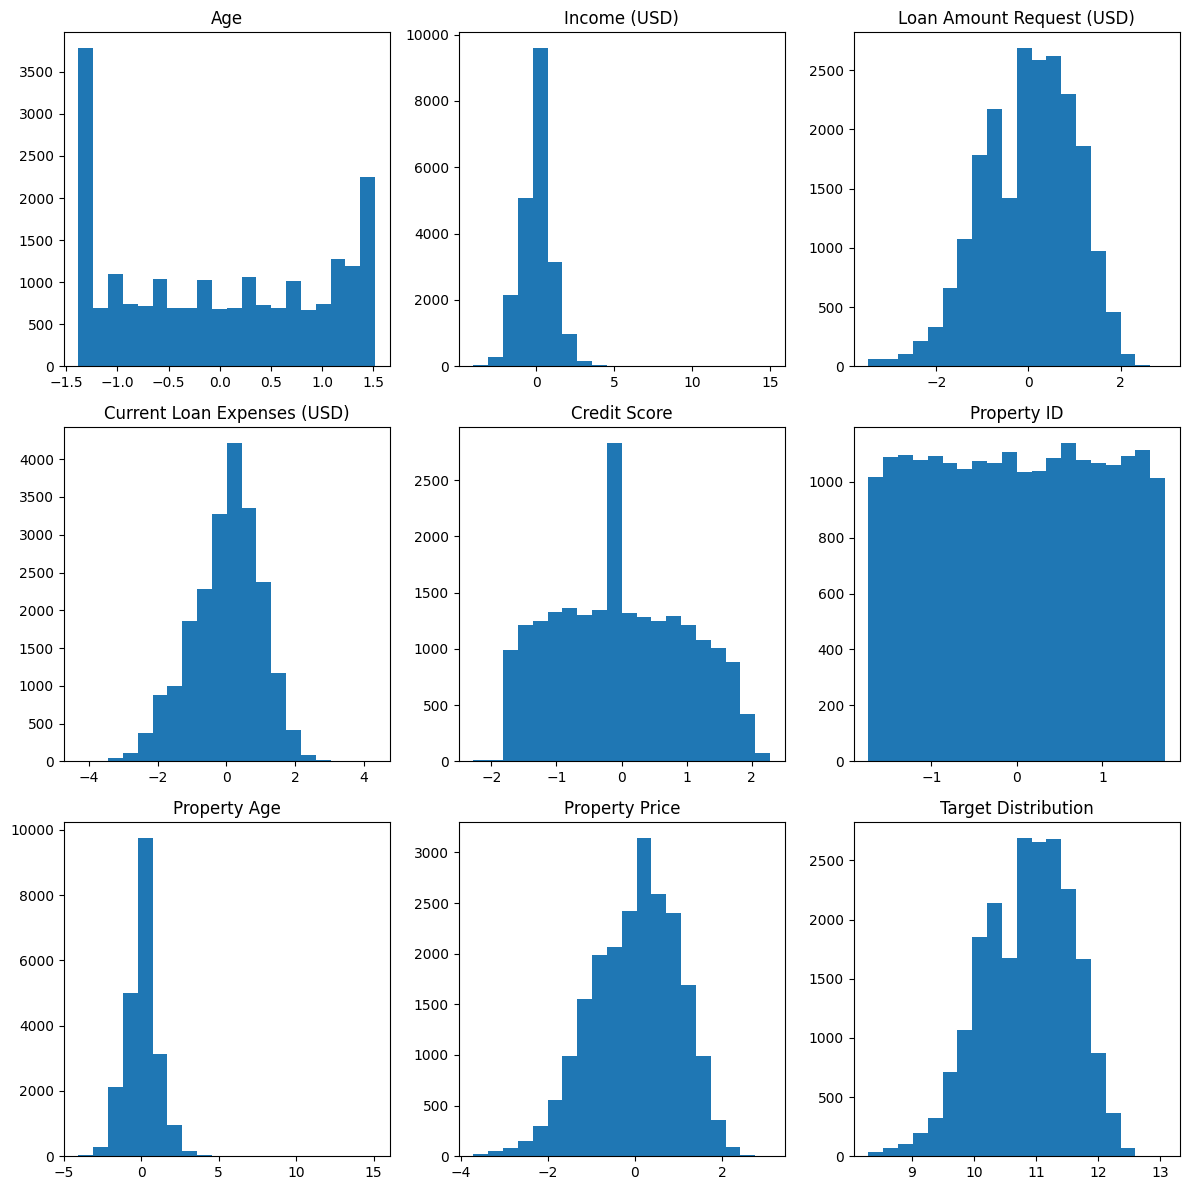

In [193]:
fig,axes = plt.subplots(nrows = 3, ncols = 3, figsize = (12,12))
axes = axes.flatten()
for i in range(8):
    axes[i].hist(X[continuous_columns[i]],bins=20)
    # axes[i].scatter(x=range(len(X)),y=X[continuous_columns[i]])
    axes[i].set_title(continuous_columns[i])

# axes[8].remove()
axes[8].hist(y[target_columns[0]], bins = 20)
axes[8].set_title("Target Distribution")

plt.tight_layout()
plt.show()

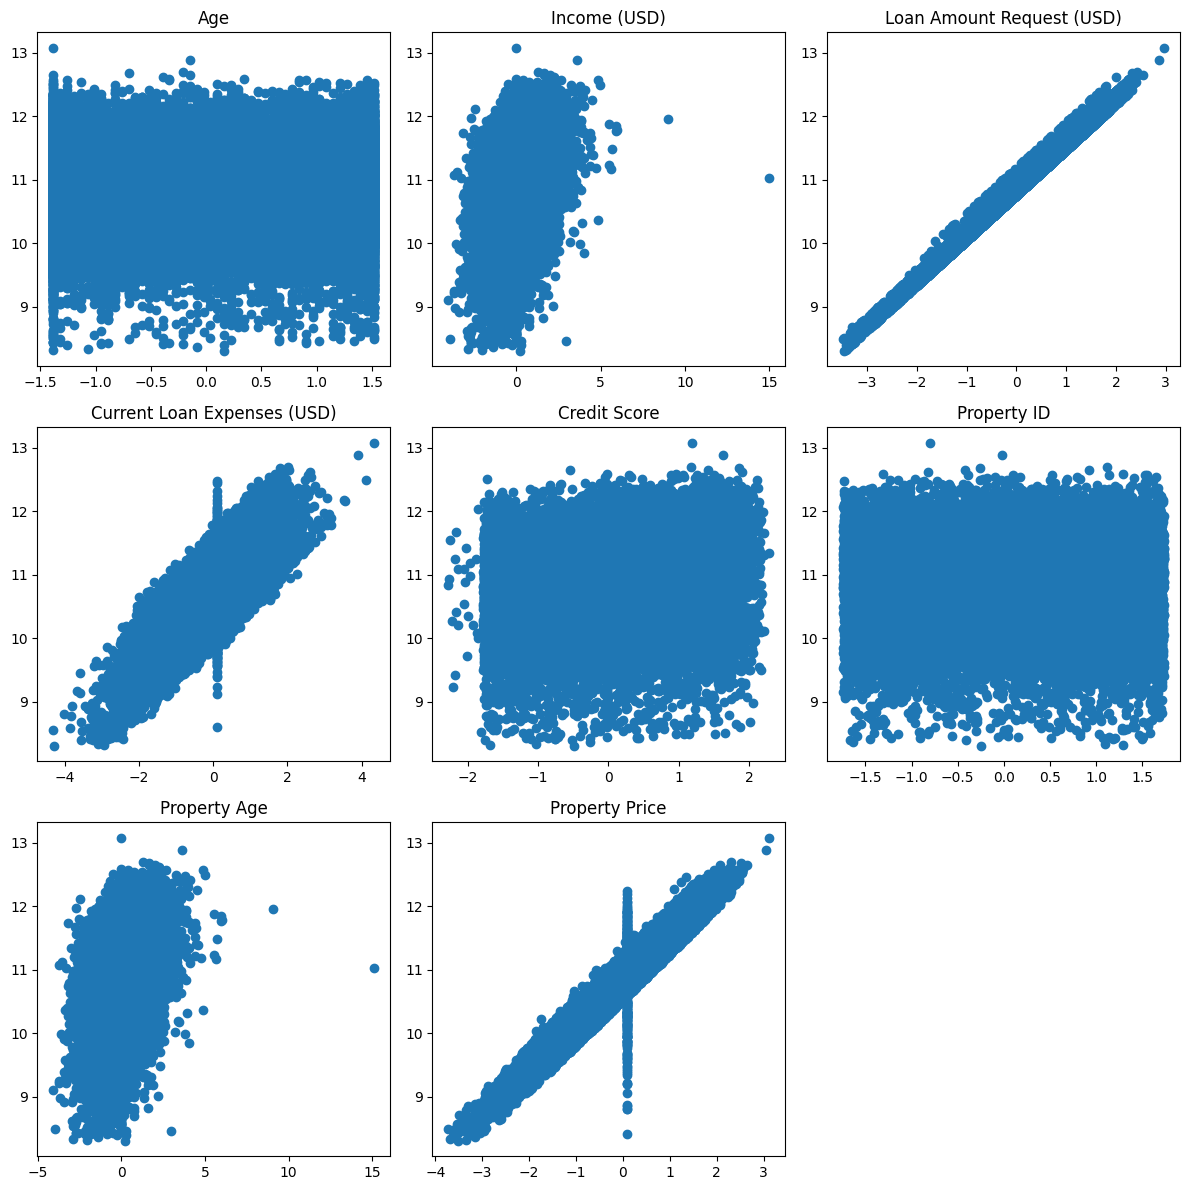

In [194]:
fig,axes = plt.subplots(nrows = 3, ncols = 3, figsize = (12,12))
axes = axes.flatten()
for i in range(8):
    axes[i].scatter(x=X[continuous_columns[i]],y=y["Loan Sanction Amount (USD)"])
    axes[i].set_title(continuous_columns[i])

axes[8].remove()

plt.tight_layout()
plt.show()

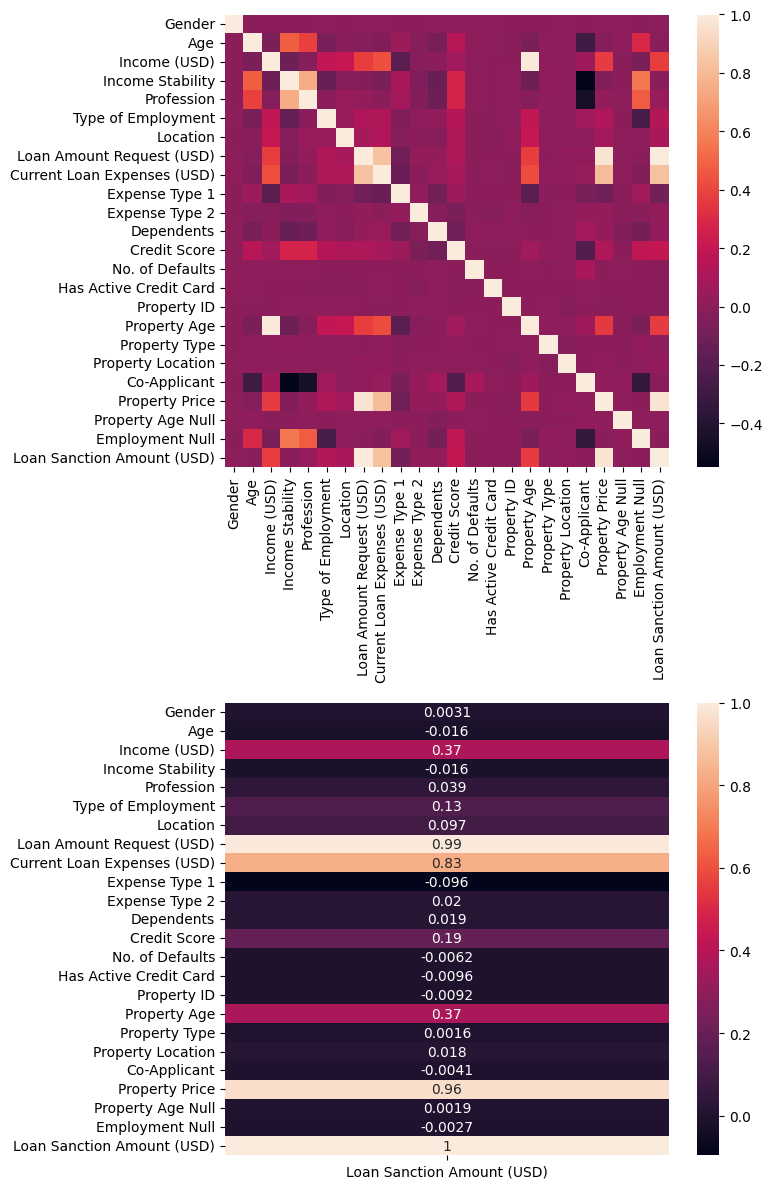

In [195]:
df = pd.concat([X,y],axis=1)

fig,axes = plt.subplots(nrows = 2, ncols=1, figsize=(8,12))

sns.heatmap(df.corr(), ax=axes[0])
sns.heatmap(df.corr()[["Loan Sanction Amount (USD)"]],ax=axes[1],annot=True)

plt.tight_layout()
plt.show()

## Splitting Dataset

In [196]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=2)

print("Training size: ", len(X_train))
print("Test size: ", len(X_test))

Training size:  17165
Test size:  4292


## Logistic regression

In [ ]:
def evaluate(model):
    start = time.time()
    model.fit(X_train, y_train)
    trained = time.time()
    y_pred = model.predict(X_test)

    print("Training time: ", trained-start)
    print("MSE: ", mean_squared_error(y_test,y_pred))
    print("MAE: ", mean_absolute_error(y_test,y_pred))
    r2 = r2_score(y_test,y_pred)

    print("R2 score: ", r2)

    n=len(X)
    p=len(X.columns)
    print("Adjusted R2 score: ", 1-(1-r2)*(n-1)/(n-p-1))
    weights = pd.DataFrame({
        'Feature': X_train.columns,
        'Weight': model.coef_
    })


    return weights





In [ ]:
linear = LinearRegression()


# evaluate(linear)




AttributeError: 'LinearRegression' object has no attribute 'coef_'